In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import itertools
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [17]:
train_dir = "/kaggle/input/pneumonia-dataset/train"
val_dir = "/kaggle/input/pneumonia-dataset/val"
test_dir = "/kaggle/input/pneumonia-dataset/test"

In [18]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,image_size=(150,150),color_mode="grayscale", shuffle= True)
val_dataset = tf.keras.utils.image_dataset_from_directory(val_dir,image_size=(150,150),color_mode="grayscale",shuffle= False)
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,image_size=(150,150),color_mode="grayscale",shuffle= False)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


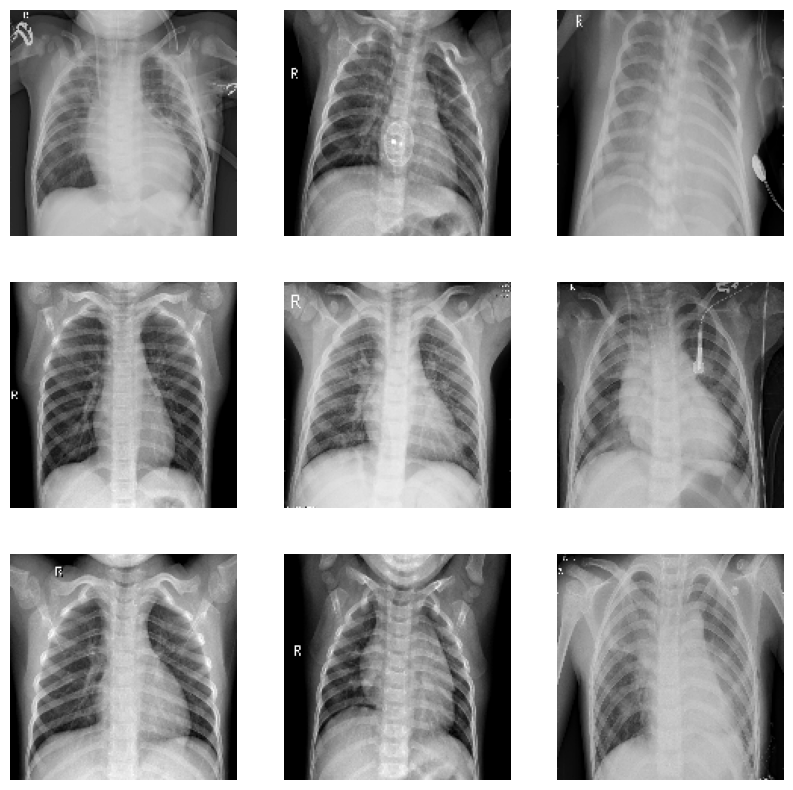

In [19]:
for images, labels in train_dataset.take(1):  
    plt.figure(figsize=(10, 10))
    for i in range(9):  
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap="gray")
        plt.axis("off")
    plt.show()

In [20]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.0833),        
    tf.keras.layers.RandomTranslation(0.1, 0.1),    
    tf.keras.layers.RandomZoom(0.2),              
    tf.keras.layers.RandomFlip("horizontal"),
])


train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)

In [21]:
rescaling_layer = tf.keras.layers.Rescaling(1./255)

train_dataset = train_dataset.map(lambda x, y: (rescaling_layer(x), y))

In [22]:
val_dataset = val_dataset.map(lambda x, y: (rescaling_layer(x), y))

In [23]:
test_dataset = test_dataset.map(lambda x, y: (rescaling_layer(x), y))

In [24]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)


In [25]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu',strides = 1 , padding = 'same', input_shape=(150, 150, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2), strides = 2),
    layers.Conv2D(64, (3, 3), padding = 'same',strides = 1 , activation='relu'),
    layers.MaxPooling2D((2, 2), strides = 2),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), padding = 'same',strides = 1 , activation='relu'),
    layers.MaxPooling2D((2, 2), strides = 2),
    layers.Dropout(0.2),
    layers.Conv2D(128, (3, 3), padding = 'same',strides = 1 , activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2), strides = 2),
    layers.Dropout(0.2),
    layers.Conv2D(256, (3, 3), padding = 'same',strides = 1 , activation='relu'),
    layers.MaxPooling2D((2, 2), strides = 2),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')  
])

In [26]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy', 'precision', 'recall'] )

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=8,
    batch_size=32,
    callbacks=[learning_rate_reduction]
)

Epoch 1/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 24s 110ms/step - accuracy: 0.7728 - loss: 1.2819 - precision: 0.8358 - recall: 0.8663 - val_accuracy: 0.5000 - val_loss: 18.6138 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 17s 103ms/step - accuracy: 0.8810 - loss: 0.3185 - precision: 0.9162 - recall: 0.9244 - val_accuracy: 0.5000 - val_loss: 7.7920 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9094 - loss: 0.2316 - precision: 0.9373 - recall: 0.9410
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 ━━━━━━━━━━━━━━━━━━━━ 18s 107ms/step - accuracy: 0.9094 - loss: 0.2315 - precision: 0.9373 - recall: 0.9410 - val_accuracy: 0.5000 - val_loss: 5.6275 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 17s 103ms/step - accuracy: 0.9373 - loss: 0.1733 - precision: 

In [27]:
#model.save('my_model1.h5')

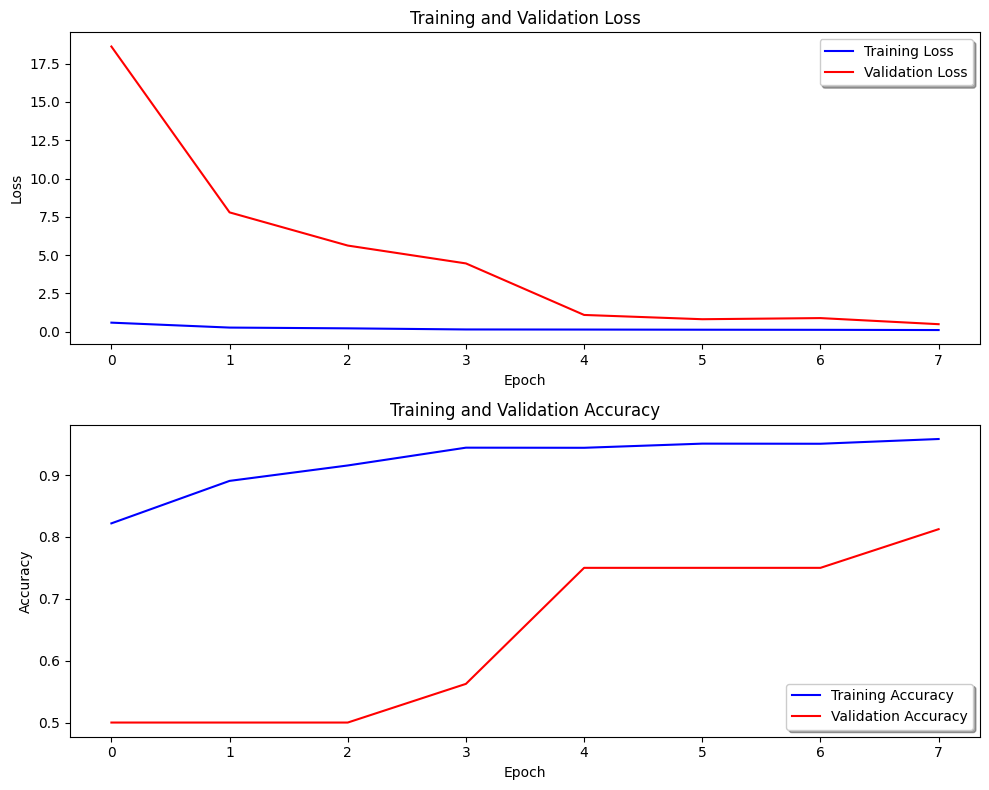

In [28]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))  

# Loss Plot
ax[0].plot(history.history['loss'], color='b', label="Training Loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation Loss")
ax[0].set_xlabel("Epoch")  
ax[0].set_ylabel("Loss")  
ax[0].set_title("Training and Validation Loss") 
ax[0].legend(loc='best', shadow=True)

# Accuracy Plot
ax[1].plot(history.history['accuracy'], color='b', label="Training Accuracy")
ax[1].plot(history.history['val_accuracy'], color='r', label="Validation Accuracy")
ax[1].set_xlabel("Epoch")  
ax[1].set_ylabel("Accuracy") 
ax[1].set_title("Training and Validation Accuracy")  
ax[1].legend(loc='best', shadow=True)

plt.tight_layout()  
plt.show()  

In [29]:
test_results = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_results[1]:.4f}")
print(f"Test Precision: {test_results[2]:.4f}")
print(f"Test Recall: {test_results[3]:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8712 - loss: 0.6924 - precision: 0.5115 - recall: 0.6328
Test Accuracy: 0.8942
Test Precision: 0.8932
Test Recall: 0.9436


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


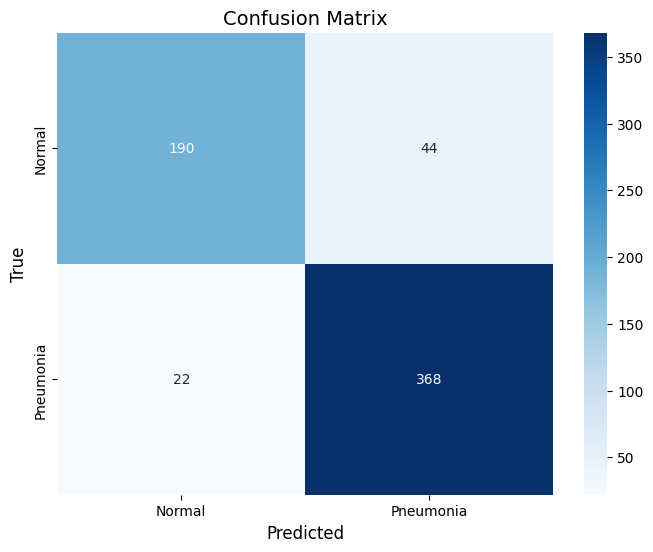

In [33]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred = model.predict(test_dataset).ravel()
y_pred = (y_pred > 0.5).astype(int)  # Apply threshold of 0.5
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

cm = confusion_matrix(y_true, y_pred)
class_names = ['Normal', 'Pneumonia']

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=14)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.show()